# Analysis of the condition media experiments
---

## 0. Environmental setup

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

scaler = StandardScaler()

In [3]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 10))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

In [4]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [5]:
def get_significant_metrics_by_fwer(pvalues, alpha):
    fwer_pvalues = pvalues/len(subset_all_features.columns)
    sign_idc = fwer_pvalues<alpha
    significant_features = np.array(subset_all_features.columns)[sign_idc]

    sign_fwer_features = dict(zip(significant_features, fwer_pvalues[sign_idc]))
    sign_fwer_features = {k: v for k, v in sorted(sign_fwer_features.items(), key=lambda item: item[1])}
    return sign_fwer_features

In [6]:
def ranksum_screen(data, labels, screen_idc = [0,1]):
    unique_labels = np.unique(labels)
    data = np.array(data)
    x = data[labels==unique_labels[screen_idc[0]],:]
    y = data[labels==unique_labels[screen_idc[1]],:]
    
    pvalues = []
    for i in range(x.shape[1]):
        pvalues.append(stats.ranksums(x[:,i], y[:,i])[1])
    return np.array(pvalues)

---
## 1. Read in data

### 1.1. Control data

In [7]:
root_dir = "../data/hmf3a_data_23_04_2021/all_features/"

control_features_2d = pd.read_csv(root_dir+"hmf3a_control_dapi_hp1_h3k9me3_features_2d.csv", index_col=0)
control_features_3d = pd.read_csv(root_dir+"hmf3a_control_dapi_hp1_h3k9me3_features_3d.csv", index_col=0)
control_features = control_features_2d.join(control_features_3d, rsuffix="_3d")

control_features["sample"] = np.repeat("ctrl", len(control_features))
control_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int,sample
HMF3A_control_DAPI_HP1_H3K9me3_1_0,0.011241,0.028630,215,0.089717,0.036993,0.033706,0.015179,8.064382,218,0.071429,...,27.123707,4.250197,0.502620,0.356472,0.0,0.079869,0.427469,27.123707,4.250197,ctrl
HMF3A_control_DAPI_HP1_H3K9me3_1_1,0.011601,0.029001,217,0.071429,0.037291,0.033706,0.015209,8.054836,216,0.071429,...,19.958184,3.681248,0.508814,0.341224,0.0,0.096559,0.441789,19.958184,3.681248,ctrl
HMF3A_control_DAPI_HP1_H3K9me3_1_2,0.010048,0.028312,258,0.075943,0.035416,0.033706,0.014456,8.712239,246,0.067891,...,35.391153,4.804525,0.433266,0.333654,0.0,0.074686,0.356953,35.391134,4.804523,ctrl
HMF3A_control_DAPI_HP1_H3K9me3_1_3,0.011307,0.027530,222,0.112288,0.035744,0.033706,0.015009,7.935213,222,0.067891,...,25.486127,4.151260,0.497422,0.350844,0.0,0.086742,0.419436,25.486114,4.151258,ctrl
HMF3A_control_DAPI_HP1_H3K9me3_1_4,0.010648,0.028715,224,0.098052,0.035823,0.033706,0.014483,8.454118,236,0.089717,...,19.291151,3.525190,0.445447,0.293916,0.0,0.127172,0.386656,19.291159,3.525192,ctrl


----

### 1.2. Condition media data

In [8]:
condition_media_features_2d = pd.read_csv(root_dir+"hmf3a_condition_media_dapi_hp1_h3k9me3_features_2d.csv", index_col=0)
condition_media_features_3d = pd.read_csv(root_dir+"hmf3a_condition_media_dapi_hp1_h3k9me3_features_3d.csv", index_col=0)
condition_media_features = condition_media_features_2d.join(condition_media_features_3d, rsuffix="_3d")

condition_media_features["sample"] = np.repeat("c_media", len(condition_media_features))
condition_media_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int,sample
HMF3A_condition_DAPI_HP1_H3K9me3_1_0,0.010041,0.029393,258,0.098052,0.037898,0.033706,0.015340,8.754414,231,0.071429,...,25.892217,4.204249,0.483544,0.345738,0.0,0.067109,0.413478,25.892229,4.204252,c_media
HMF3A_condition_DAPI_HP1_H3K9me3_1_1,0.010845,0.028550,223,0.089717,0.037401,0.033706,0.015754,8.078616,216,0.071429,...,19.412767,3.608881,0.494986,0.326303,0.0,0.097268,0.427592,19.412763,3.608879,c_media
HMF3A_condition_DAPI_HP1_H3K9me3_1_2,0.011643,0.026207,214,0.098052,0.036177,0.033706,0.013745,7.488574,207,0.058785,...,16.445615,3.431439,0.518359,0.347137,0.0,0.106297,0.443069,16.445623,3.431441,c_media
HMF3A_condition_DAPI_HP1_H3K9me3_1_3,0.010358,0.026496,243,0.103945,0.035206,0.033706,0.013773,8.132597,231,0.058785,...,25.481515,4.161441,0.473122,0.341529,0.0,0.072053,0.404482,25.481521,4.161443,c_media
HMF3A_condition_DAPI_HP1_H3K9me3_1_4,0.011083,0.029876,241,0.089717,0.038890,0.033706,0.016284,8.400163,216,0.067891,...,13.575033,3.209479,0.561637,0.330360,0.0,0.085222,0.501374,13.575026,3.209479,c_media


---
### 1.3. TNFa 5ng data

In [9]:
tnfa5_features_2d = pd.read_csv(root_dir+"hmf3a_tnfa5ng_dapi_hp1_actin_features_2d.csv", index_col=0)
tnfa5_features_3d = pd.read_csv(root_dir+"hmf3a_tnfa5ng_dapi_hp1_actin_features_3d.csv", index_col=0)
tnfa5_features = tnfa5_features_2d.join(tnfa5_features_3d, rsuffix="_3d")

tnfa5_features["sample"] = np.repeat("tnfa5", len(tnfa5_features))
tnfa5_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int,sample
HMF3A_Dapi_HP1__actin_15_4_21_2X_12bit_TNFalfa5ng_1_0,0.010709,0.030327,223,0.089717,0.038339,0.033706,0.015934,8.664575,226,0.071429,...,14.914267,3.297539,0.455270,0.277610,0.0,0.084699,0.396298,14.914264,3.297539,tnfa5
HMF3A_Dapi_HP1__actin_15_4_21_2X_12bit_TNFalfa5ng_1_1,0.011173,0.027465,231,0.079597,0.037646,0.033706,0.015228,7.792716,207,0.067891,...,18.278698,3.638717,0.491974,0.315311,0.0,0.077131,0.414580,18.278694,3.638716,tnfa5
HMF3A_Dapi_HP1__actin_15_4_21_2X_12bit_TNFalfa5ng_1_2,0.011823,0.028952,224,0.098052,0.036226,0.033706,0.014908,8.114712,224,0.067891,...,15.018660,3.231264,0.472769,0.288028,0.0,0.114365,0.409014,15.018659,3.231265,tnfa5
HMF3A_Dapi_HP1__actin_15_4_21_2X_12bit_TNFalfa5ng_1_3,0.013280,0.026147,180,0.075943,0.036717,0.035101,0.013906,6.976144,190,0.067891,...,10.290904,2.747048,0.469219,0.295501,0.0,0.228301,0.402068,10.290907,2.747049,tnfa5
HMF3A_Dapi_HP1__actin_15_4_21_2X_12bit_TNFalfa5ng_1_4,0.010408,0.031428,246,0.089717,0.038292,0.033706,0.015974,9.036855,236,0.089717,...,20.988204,3.898049,0.461009,0.312175,0.0,0.072922,0.385951,20.988206,3.898051,tnfa5


---
### TNFa 10ng data

In [10]:
tnfa10_features_2d = pd.read_csv(root_dir+"hmf3a_tnfa10ng_dapi_hp1_actin_features_2d.csv", index_col=0)
tnfa10_features_3d = pd.read_csv(root_dir+"hmf3a_tnfa10ng_dapi_hp1_actin_features_3d.csv", index_col=0)
tnfa10_features = tnfa10_features_2d.join(tnfa10_features_3d, rsuffix="_3d")

tnfa10_features["sample"] = np.repeat("tnfa10", len(tnfa10_features))
tnfa10_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int,sample
HMF3A_Dapi_HP1__actin_14_4_21_2X_12bit_TNFalfa10ng_2_0,0.006065,0.048408,185,0.500000,0.041243,0.033706,0.052358,7.465011,181,0.237472,...,6.222007,2.444599,0.595208,0.253451,0.0,0.063967,0.567094,6.222007,2.444599,tnfa10
HMF3A_Dapi_HP1__actin_14_4_21_2X_12bit_TNFalfa10ng_2_1,0.007771,0.046716,184,0.211254,0.043768,0.033706,0.032631,9.103722,208,0.199447,...,6.527049,2.481710,0.635801,0.268925,0.0,0.071996,0.602025,6.527052,2.481710,tnfa10
HMF3A_Dapi_HP1__actin_14_4_21_2X_12bit_TNFalfa10ng_2_2,0.013677,0.026985,187,0.089717,0.036078,0.036495,0.013612,7.179468,199,0.067891,...,5.195445,2.066392,0.567442,0.263040,0.0,0.278863,0.527580,5.195447,2.066393,tnfa10
HMF3A_Dapi_HP1__actin_14_4_21_2X_12bit_TNFalfa10ng_2_3,0.013024,0.027012,186,0.075943,0.036532,0.033706,0.014200,7.196796,197,0.067891,...,3.406793,1.798274,0.554673,0.220119,0.0,0.296823,0.526218,3.406794,1.798274,tnfa10
HMF3A_Dapi_HP1__actin_14_4_21_2X_12bit_TNFalfa10ng_2_4,0.011019,0.029202,227,0.098052,0.036710,0.033706,0.015079,8.369955,228,0.071429,...,8.631519,2.625958,0.569871,0.250348,0.0,0.100588,0.533892,8.631518,2.625957,tnfa10


---

## 2. Data preprocessing

We will now preprocess the data for the downstream analyses.

In [11]:
all_features = control_features.append(condition_media_features).append(tnfa5_features).append(tnfa10_features)
all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_hp1_int,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,...,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.011080,0.029575,224.408313,0.097772,0.037021,0.034309,0.015811,8.394806,225.968215,0.079394,...,677.977995,14.647075,3.042208,0.490123,0.266378,0.000173,0.137857,0.443195,14.647075,3.042208
std,0.001432,0.006302,30.486208,0.040163,0.003455,0.002806,0.004650,1.563665,21.148436,0.040080,...,288.652765,10.823147,1.045609,0.060685,0.060222,0.000666,0.075711,0.068104,10.823146,1.045609
min,0.003999,0.024340,132.000000,0.067891,0.033230,0.033706,0.011855,6.655305,180.000000,0.037563,...,174.000000,-0.344827,0.862792,0.311437,0.108642,0.000000,0.024944,0.286794,-0.344829,0.862791
25%,0.010157,0.027123,203.000000,0.089717,0.035547,0.033706,0.014048,7.689522,213.000000,0.067891,...,417.000000,5.934192,2.208564,0.446024,0.229271,0.000000,0.079674,0.393639,5.934189,2.208564
50%,0.010907,0.028497,226.000000,0.089717,0.036453,0.033706,0.015008,8.183865,224.000000,0.071429,...,660.000000,10.712720,2.767659,0.485923,0.262625,0.000000,0.116029,0.438886,10.712732,2.767660
75%,0.011930,0.029832,244.000000,0.098052,0.037473,0.033706,0.016030,8.799377,237.000000,0.071429,...,899.000000,22.977466,3.951697,0.527968,0.320848,0.000000,0.184579,0.489308,22.977472,3.951696
max,0.015460,0.094695,305.000000,0.500000,0.078858,0.071429,0.056105,25.786525,351.000000,0.387426,...,1575.000000,51.485866,5.960161,0.731683,0.383494,0.004183,0.355518,0.721778,51.485861,5.960160


### 2.1. Remove constant and NA samples

In [12]:
# Remove constant features for control data
cleaned_all_features = all_features.loc[:, (all_features != all_features.iloc[0]).any()]
cleaned_all_features = cleaned_all_features.dropna(axis=1, how='all')
# Remove rows with missing entries in the control data
cleaned_all_features = cleaned_all_features.dropna(axis=0)
print("{} rows and {} columns were dropped.".format(str(len(all_features)-len(cleaned_all_features)), 
                                                                         str(len(all_features.columns)-len(cleaned_all_features.columns))))

7 rows and 8 columns were dropped.


### 2.2. Remove manually selected nuclei
We next filter out some nuclei that we found to show nuclear blebbs or where in a pro-metaphase stage or where the segmentation introduced some artifacts.

In [13]:
nuclei_to_filter = pd.read_csv("../data/hmf3a_data_23_04_2021/all_features/filtered_nuclei.txt", header=None).iloc[:,0]
print("Found {} nuclei to filter out.".format(len(nuclei_to_filter)))

Found 19 nuclei to filter out.


In [14]:
cleaned_all_features = cleaned_all_features.drop(list(nuclei_to_filter))

In [15]:
cleaned_all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_hp1_int,kurtosis_hp1_int,skewness_hp1_int,normalized_mean_hp1_int,normalized_std_hp1_int,normalized_q25_hp1_int,normalized_q75_hp1_int,normalized_median_hp1_int,normalized_kurtosis_hp1_int,normalized_skewness_hp1_int
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,...,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.011137,0.028607,225.417755,0.091975,0.036578,0.034014,0.015160,8.227766,224.966057,0.072613,...,677.334204,14.969998,3.072655,0.489942,0.268099,0.000172,0.137124,0.442501,14.969998,3.072655
std,0.001272,0.002569,29.291957,0.018339,0.001634,0.000921,0.002497,0.733964,17.618303,0.018304,...,291.842294,10.928570,1.050863,0.057909,0.059746,0.000661,0.075275,0.066269,10.928569,1.050863
min,0.008322,0.024340,132.000000,0.067891,0.033230,0.033706,0.011855,6.655305,180.000000,0.037563,...,174.000000,-0.344827,0.956681,0.352859,0.117686,0.000000,0.024944,0.288753,-0.344829,0.956680
25%,0.010201,0.027066,204.500000,0.086867,0.035486,0.033706,0.013988,7.690309,213.000000,0.067891,...,411.000000,5.963705,2.215191,0.448071,0.229281,0.000000,0.079339,0.393843,5.963704,2.215191
50%,0.010950,0.028392,227.000000,0.089717,0.036378,0.033706,0.014978,8.177117,224.000000,0.071429,...,660.000000,11.096844,2.803613,0.485216,0.265004,0.000000,0.115056,0.437123,11.096847,2.803613
75%,0.011899,0.029648,243.500000,0.098052,0.037359,0.033706,0.015917,8.714440,237.000000,0.071429,...,899.500000,23.460158,3.971957,0.525494,0.322698,0.000000,0.184168,0.486888,23.460154,3.971957
max,0.015460,0.054481,305.000000,0.285714,0.047429,0.037563,0.042881,10.972638,280.000000,0.333333,...,1575.000000,51.485866,5.960161,0.731683,0.383494,0.004183,0.355518,0.721778,51.485861,5.960160


### 2.2. Control batch effects

To check if there are significant batch effects even before further dimensionality reduction, we will plot some general morphological features that should constant between technical replicates.

In [44]:
Counter(cleaned_all_features["sample"])

Counter({'ctrl': 74, 'c_media': 88, 'tnfa5': 135, 'tnfa10': 86})

#### Volume

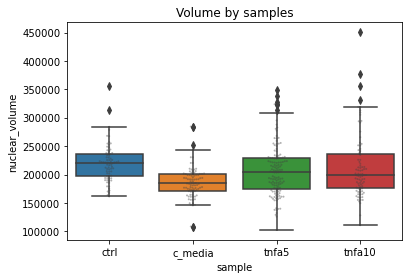

In [16]:
ax = sns.boxplot(x="sample", y="nuclear_volume", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="nuclear_volume", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Volume by samples")
plt.show()

In [125]:
x = cleaned_all_features.loc[cleaned_all_features["sample"]=="c_media", "max_hp1_int"]
y = cleaned_all_features.loc[cleaned_all_features["sample"]=="tnfa5", "max_hp1_int"]

x = np.array(x[x != np.nan])
y = np.array(y[y != np.nan])

In [126]:
stats.ranksums(x, y)[1]

5.3690093919797845e-05

#### Area (max-z projection)

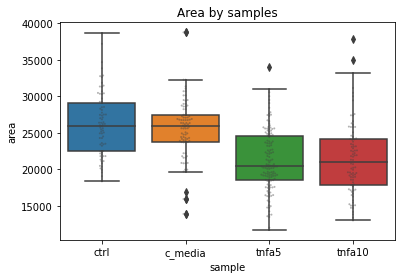

In [17]:
ax = sns.boxplot(x="sample", y="area", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="area", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Area by samples")
plt.show()

#### Median intensity in the nucleus (max z-projection)

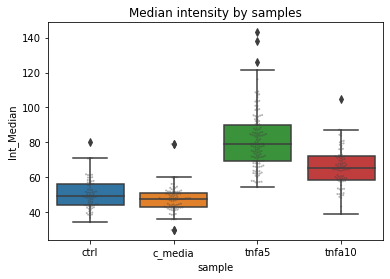

In [20]:
ax = sns.boxplot(x="sample", y="Int_Median", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="Int_Median", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Median intensity by samples")
plt.show()

### 2.2. Remove highly correlated features


In [21]:
# Maintain features that have at most a Pearson correlation of 0.75
threshold = 0.70
sample_labels = np.array(cleaned_all_features["sample"])
# Get correlation structure
cleaned_all_features_corr_matrix = cleaned_all_features.corr().abs()
upper = cleaned_all_features_corr_matrix.where(np.triu(np.ones(cleaned_all_features_corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)] + ["label"] +["bbox-1"] + ["sample"]
len(to_drop)

203

We drop 203 of the features that show a high autocorrelation (larger than 0.7) plus 3 that are artifacts from the segmentation.

In [22]:
subset_all_features = cleaned_all_features.drop(to_drop, axis=1)
# hp1_features = []
# for c in cleaned_all_data.columns:
#     if "hp1" in c:
#         hp1_features.append(c)
        
# cleaned_all_data = cleaned_all_data.drop(hp1_features, axis=1)

subset_all_features.describe()

,Avg_Curvature,Std_Curvature,Med_posi_Curvature,Med_neg_Curvature,num_prominant_positive_curvature,prominance_prominant_positive_curvature,width_prominant_positive_curvature,num_prominant_negative_curvature,prominance_prominant_negative_curvature,width_prominant_negative_curvature,...,moments_hu-2,moments_hu-3,moments_hu-5,Concavity,Center_Mismatch,Frac_Peri_w_polarity_changes,extent,solidity,max_hp1_int,q25_hp1_int
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,...,3.830000e+02,3.830000e+02,3.830000e+02,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.011137,0.028607,0.034014,0.033469,4.913838,0.124167,5.963332,6.848564,0.118678,6.562076,...,7.519335e-06,7.650621e-08,6.658216e-10,0.009886,1.240766,0.393409,0.523710,0.862590,3501.065274,0.352480
std,0.001272,0.002569,0.000921,0.001621,2.153869,0.012873,0.725258,2.688553,0.009052,0.822849,...,1.154327e-05,2.696693e-07,1.009436e-08,0.001460,0.769665,0.023406,0.035290,0.033936,663.080842,1.366594
min,0.008322,0.024340,0.033706,0.027695,1.000000,0.101597,5.020721,1.000000,0.103911,5.105555,...,1.626015e-09,1.187057e-12,-1.031127e-07,0.007535,0.145230,0.318180,0.363520,0.639371,1293.000000,0.000000
25%,0.010201,0.027066,0.033706,0.033706,3.000000,0.116069,5.469545,5.000000,0.112061,5.950694,...,1.787361e-06,2.424321e-09,-9.207376e-11,0.009062,0.702435,0.378166,0.499332,0.847292,2993.000000,0.000000
50%,0.010950,0.028392,0.033706,0.033706,5.000000,0.123375,5.768955,7.000000,0.117833,6.451557,...,3.973252e-06,1.237341e-08,1.465319e-13,0.009739,1.110904,0.393694,0.526933,0.866436,3740.000000,0.000000
75%,0.011899,0.029648,0.033706,0.033706,6.000000,0.130643,6.202528,9.000000,0.122904,7.064773,...,9.339221e-06,4.886995e-08,1.938720e-10,0.010305,1.594848,0.409562,0.548905,0.885078,4095.000000,0.000000
max,0.015460,0.054481,0.037563,0.037563,15.000000,0.236899,10.949974,15.000000,0.157608,11.087089,...,1.477164e-04,4.015092e-06,8.203161e-08,0.019968,7.109475,0.453289,0.613321,0.928443,4095.000000,9.000000


In [23]:
np.unique(subset_all_features.columns)

array(['Avg_Curvature', 'Center_Mismatch', 'Concavity',
       'Frac_Peri_w_polarity_changes', 'HC_area_EC_area', 'I80_I20',
       'Int_Max', 'Int_Min', 'Med_neg_Curvature', 'Med_posi_Curvature',
       'Std_Curvature', 'Std_Radius', 'correlation_1', 'correlation_5',
       'extent', 'max_hp1_int', 'moments_central-0-1',
       'moments_central-1-0', 'moments_hu-2', 'moments_hu-3',
       'moments_hu-5', 'moments_normalized-0-2', 'moments_normalized-1-2',
       'nHigh_nLow', 'num_prominant_negative_curvature',
       'num_prominant_positive_curvature', 'orientation',
       'prominance_prominant_negative_curvature',
       'prominance_prominant_positive_curvature', 'q25_hp1_int',
       'solidity', 'weighted_moments-0-0', 'weighted_moments_central-0-1',
       'weighted_moments_central-1-0', 'weighted_moments_hu-2',
       'weighted_moments_hu-3', 'weighted_moments_hu-6',
       'weighted_moments_normalized-0-3',
       'weighted_moments_normalized-1-1',
       'weighted_moments_norm

In [24]:
Counter(sample_labels)

Counter({'ctrl': 74, 'c_media': 88, 'tnfa5': 135, 'tnfa10': 86})

In [25]:
sample_changes = list(Counter(sample_labels).values())

---

## 3. Data visualization

We will now visualize the cleaned data that consists of 52 features after our filtering and 302 samples of the control conditiona nd 185 samples of the treatment condition.

### 3.1. tSNE visualization

In [26]:
random.seed(1234)
tsne = TSNE(n_components=2, perplexity=30, random_state=1234)
scaled_subset_all_features = StandardScaler().fit_transform(subset_all_features)
embedded_subset_features = tsne.fit_transform(scaled_subset_all_features)

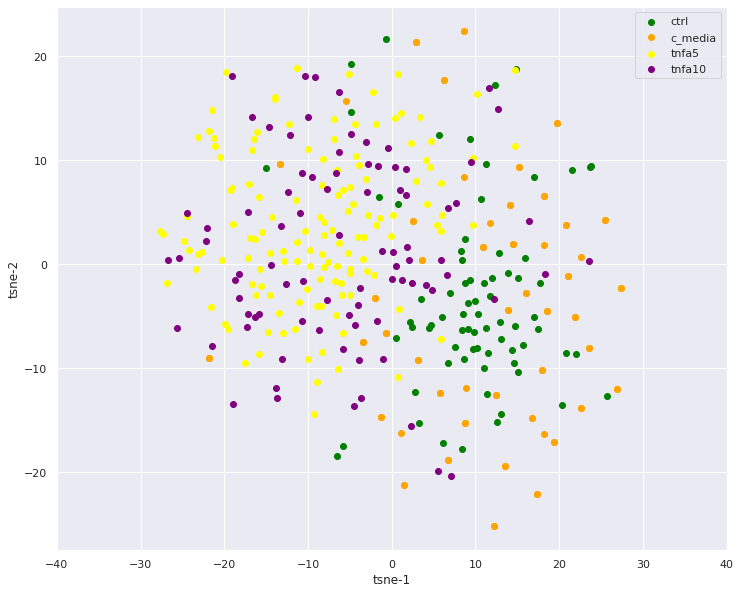

In [27]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)

x = embedded_subset_features[:,0]
y = embedded_subset_features[:,1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
colors = ["green", "orange", "yellow", "purple", "black"]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(x[j:end], y[j:end], c=colors[i], label=list(Counter(sample_labels).keys())[i])
    j = end
ax.set_xlim([-40,40])
ax.legend()
plt.show()

### 3.2. PCA visualization

In [28]:
pca = PCA(n_components=2, random_state=1234)
embedded_subset_features = pca.fit_transform(scaled_subset_all_features)
expl_var_ratio = pca.explained_variance_ratio_

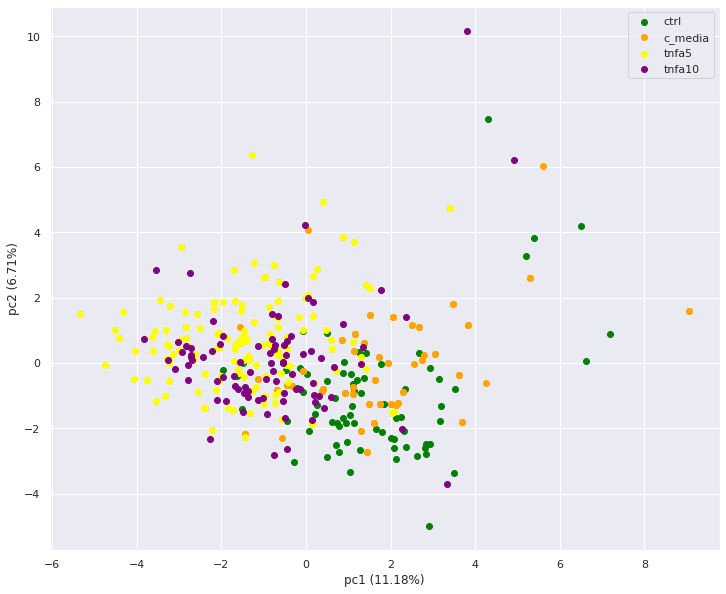

In [29]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)

x = embedded_subset_features[:,0]
y = embedded_subset_features[:,1]
ax.set_xlabel("pc1 ({}%)".format(np.round(expl_var_ratio[0]*100,2)))
ax.set_ylabel("pc2 ({}%)".format(np.round(expl_var_ratio[1]*100,2)))

colors = ["green", "orange", "yellow", "purple", "black"]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(x[j:end], y[j:end], c=colors[i], label=list(Counter(sample_labels).keys())[i])
    j = end
ax.legend()
plt.show()

## 4. Differences between the two conditions

We will now assess how dissimilar the treatment and the control condition samples are.

### 4.1. Random Forest classification

We fit a RandomForest classifier to see how well this algorithm often used as a baseline approach can separate the treatment from the control samples and in particular which features are most valuable for distinguishing those.

To this end, we first perform 10-fold stratified cross-validation to separate between the different samples and assess the accuracy and balanced accuracy of the classifier.

#### 4.1.1. Accuracy & balanced accuracy

In [30]:
rfc = RFC(n_estimators=100, random_state=1234, n_jobs=5, class_weight="balanced")
cv_results = cross_validate(rfc, scaled_subset_all_features, sample_labels, cv=10, scoring=["accuracy", "balanced_accuracy"])

In [31]:
cv_results = pd.DataFrame(cv_results)
cv_results.describe()

,fit_time,score_time,test_accuracy,test_balanced_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.164956,0.029783,0.796559,0.775721
std,0.128733,0.004331,0.082630,0.095069
min,0.111761,0.022283,0.684211,0.607143
25%,0.121001,0.027157,0.718792,0.710165
50%,0.124055,0.030856,0.815789,0.793746
75%,0.132395,0.032198,0.868421,0.854167
max,0.530794,0.035532,0.894737,0.883929


We see that we get an average accuracy of roughly 78.89% and a balanced accuracy of 76.86%. The difference can be explained by the fact that our model seems to perform worse on some minority classes.

#### 4.1.2. Individual ROC curves

Next, we turn the multi-class classification problem into several binary classification problems basically fitting one RFC classifier for a certain class vs the rest.
Below we plot the resulting ROC curves for a 10-fold stratified cross-validation approach.

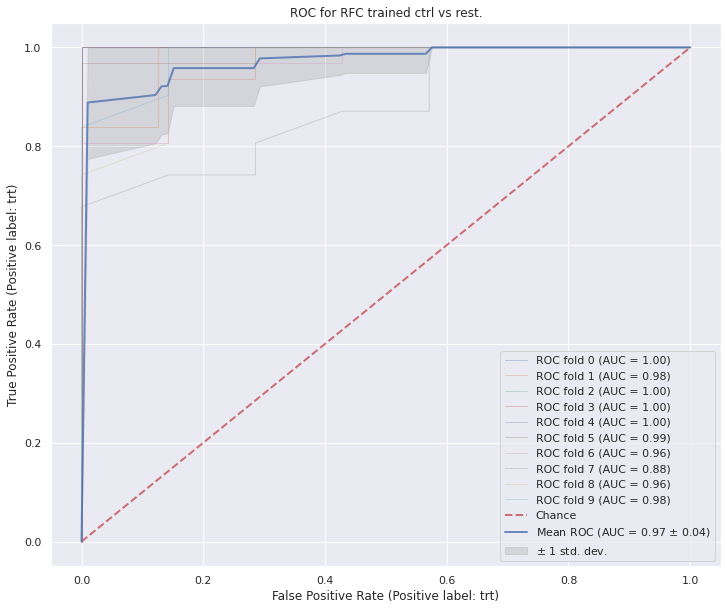

In [32]:
binarized_labels = np.repeat("trt", len(sample_labels))
binarized_labels[sample_labels == "ctrl"] = "ctrl"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained ctrl vs rest.")

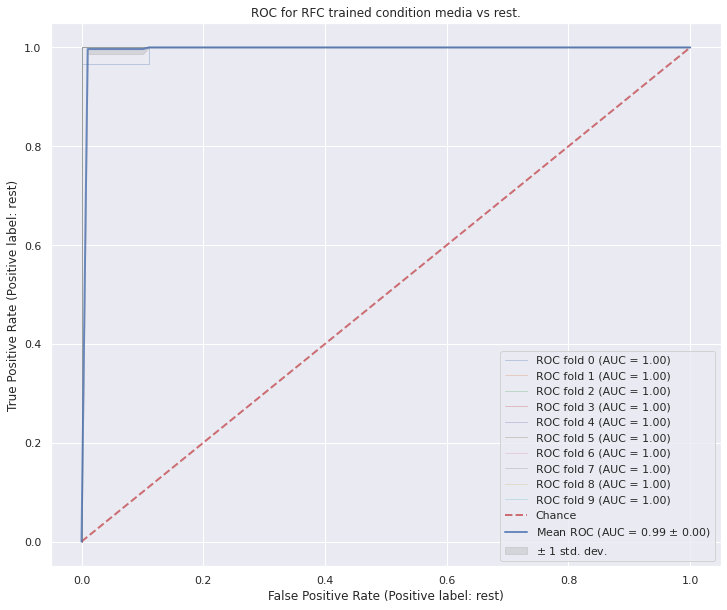

In [33]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "c_media"] = "c_media"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained condition media vs rest.")

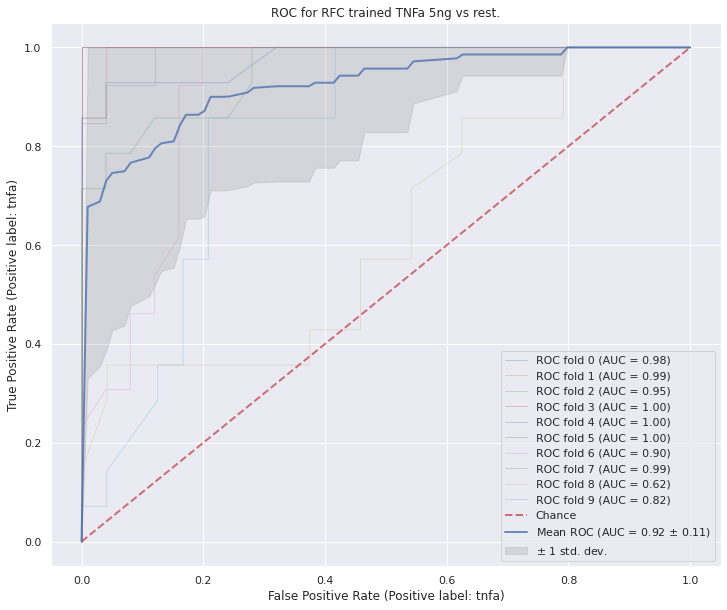

In [34]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "tnfa5"] = "tnfa5"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained TNFa 5ng vs rest.")

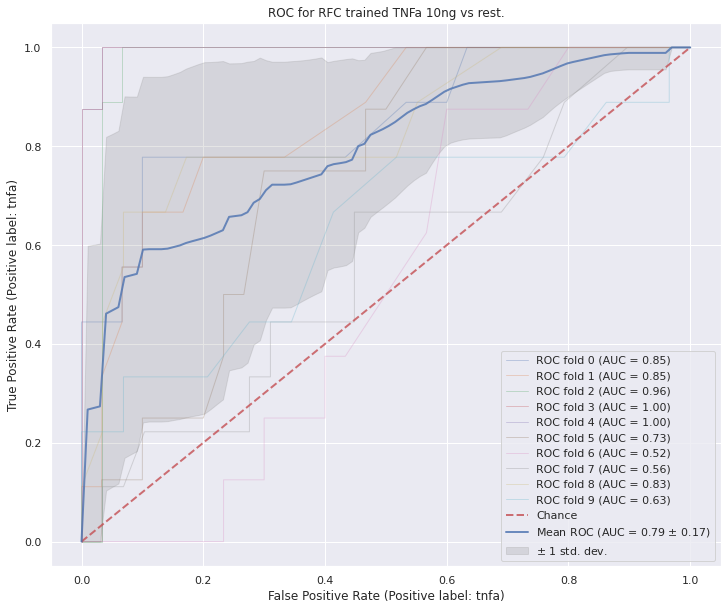

In [35]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "tnfa10"] = "tnfa10"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained TNFa 10ng vs rest.")

We see that the model performs fairly good when trained to separate the nuclei from the control setting from all others respectively also the ones from the condition-media setting. Identifying samples from the TNFa treatment condition is substantially more difficult. 

#### 4.1.3. Confusion matrix

This fact is also reflected in the confusion matrix for a test dataset that we generate by holding out 50% of the data sampled in a stratified manner before training the model.

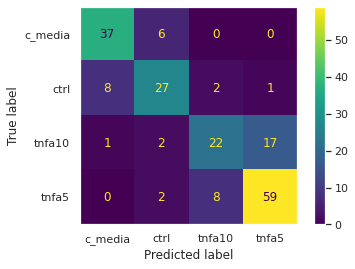

In [36]:
features_train, features_test, labels_train, labels_test = train_test_split(scaled_subset_all_features, sample_labels, 
                                                                             test_size=0.5, random_state=1234)
fitted_rfc = rfc.fit(features_train, labels_train)
disp = plot_confusion_matrix(rfc, features_test, labels_test)
plt.grid(b=None)
plt.show()

#### 4.1.4. Feature importance

Next, we will look at which features are the most discriminative between the classes in general. To this end we look at the feature importance of the RFC which we trained on 50% of the data.

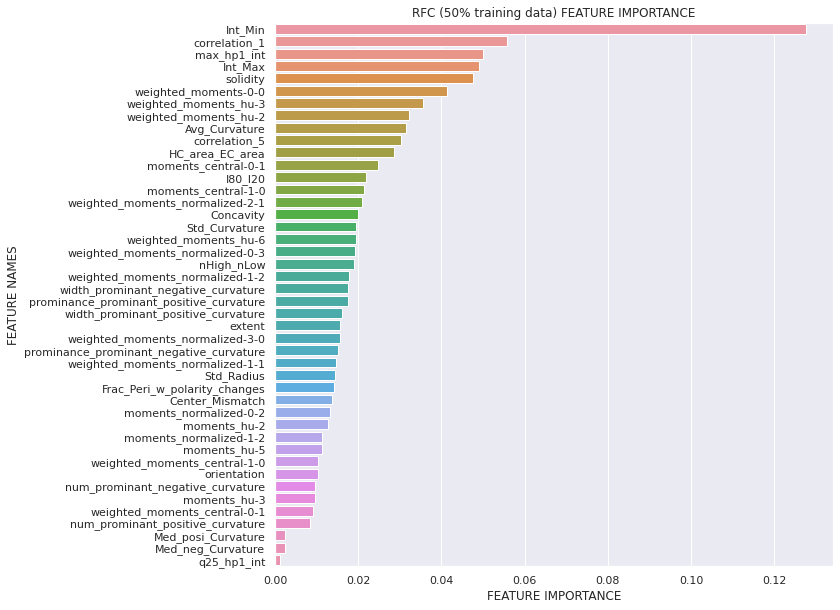

In [37]:
plot_feature_importance(fitted_rfc.feature_importances_, subset_all_features.columns, "RFC (50% training data) ")

The fact that the minimum DAPI intensity of the max-z projection of the nucleus is by far the most important one to discriminate between the classes is unexpected. Similarly, we find that the maximum HP1 intensity as well as the maxium DAPI intensity are among the five most important features to discriminate between these.

Since we do not have seen previously any strong batch-effects this unlikely a batch effect. To verify this - one would however rerun the analysis using two additional technical replicates.

### 4.2. Hypothesis testing

We will now test all of the 44 features we have left with respect to their significance in the differences between the the different experimental conditions using the Wilcoxon rank sum test.

#### 4.2.1. Control vs condition media

In [38]:
pvalues_ctrl_vs_cond_media = ranksum_screen(subset_all_features, sample_labels)

In [39]:
get_significant_metrics_by_fwer(pvalues_ctrl_vs_cond_media, alpha=0.001)

{'correlation_1': 1.1335555511619911e-14,
 'max_hp1_int': 7.173001031945187e-12,
 'solidity': 5.781484176837542e-09,
 'extent': 1.2043214229320973e-07,
 'weighted_moments_hu-6': 3.8343389632319215e-05,
 'Concavity': 0.00017255065589642432,
 'Std_Radius': 0.00032974843656406847,
 'moments_hu-3': 0.0006501375901166829,
 'weighted_moments-0-0': 0.0008857599259273999}

The most significantly different features between these two conditions are the the are cross-correlation metric describing the texture nuclei in 2D (using max-z projection), the maximum HP1 intensity, followed by the solidity which is a measure for the convexity of the nucleus and the extent and the latter describes the how cuboid-like the 3D shape of the nucleus is.

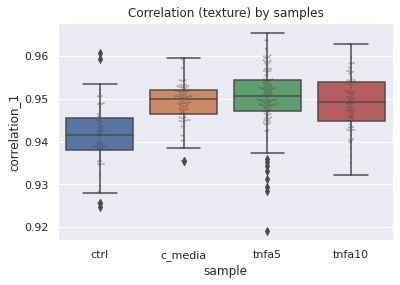

In [40]:
ax = sns.boxplot(x="sample", y="correlation_1", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="correlation_1", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
plt.title("Correlation (texture) by samples")
plt.show()

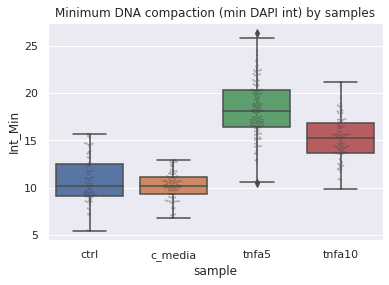

In [41]:
ax = sns.boxplot(x="sample", y="Int_Min", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="Int_Min", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
plt.title("Minimum DNA compaction (min DAPI int) by samples")
plt.show()

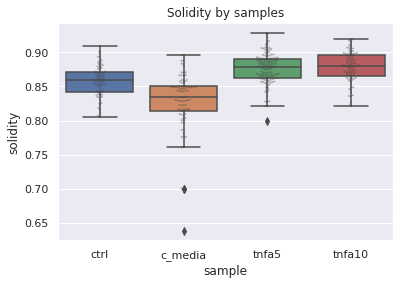

In [42]:
ax = sns.boxplot(x="sample", y="solidity", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="solidity", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
plt.title("Solidity by samples")
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


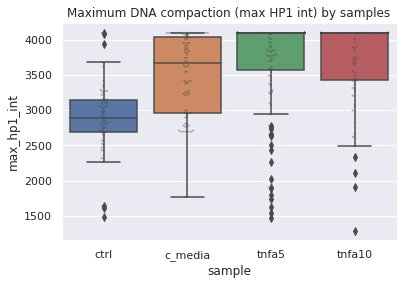

In [43]:
ax = sns.boxplot(x="sample", y="max_hp1_int", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="max_hp1_int", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
plt.title("Maximum DNA compaction (max HP1 int) by samples")
plt.show()

#### 4.2.2. Control vs TNFa treatement (5ng)

In [148]:
pvalues_ctrl_vs_tnfa5 = ranksum_screen(subset_all_features, sample_labels, screen_idc=[0,2])

In [161]:
get_significant_metrics_by_fwer(pvalues_ctrl_vs_tnfa5, alpha=0.001)

{'Int_Min': 1.5003650857940208e-28,
 'solidity': 5.671364034000402e-20,
 'Avg_Curvature': 3.7441087790148243e-11,
 'weighted_moments_hu-3': 9.112963236756797e-10,
 'Std_Curvature': 1.8636474572741333e-08,
 'HC_area_EC_area': 6.890029601171473e-08,
 'correlation_5': 1.9340527061481765e-07,
 'prominance_prominant_positive_curvature': 2.1034731143954127e-07,
 'num_prominant_negative_curvature': 5.58551431195162e-07,
 'weighted_moments_hu-2': 1.5312291083328706e-06,
 'nHigh_nLow': 6.982916321818027e-06,
 'prominance_prominant_negative_curvature': 7.229968886654419e-06,
 'max_hp1_int': 1.5152285873718147e-05,
 'extent': 4.667679459318549e-05,
 'width_prominant_negative_curvature': 5.162244307804147e-05,
 'Int_Max': 8.154760316180083e-05,
 'width_prominant_positive_curvature': 0.00015899250387364124,
 'I80_I20': 0.00016335702556460275,
 'num_prominant_positive_curvature': 0.00021328592916425372,
 'weighted_moments-0-0': 0.0007688084969607465,
 'moments_hu-5': 0.0008528954581091097}

The most significantly differently changing features between the control and treatment condition with TNFalpha (5ng) are the minimum DNA compection inside the nucleus (computed as the minimum intensity of the max-z projected nucleus), followed by the solidity, the average curvature and the HC/EC ratio computed in 2d.

#### 4.2.3. Control vs TNFa (10ng)

In [150]:
pvalues_ctrl_vs_tnfa10 = ranksum_screen(subset_all_features, sample_labels, screen_idc=[0,3])

In [162]:
get_significant_metrics_by_fwer(pvalues_ctrl_vs_tnfa10, alpha=0.001)

{'Int_Min': 3.003906484739684e-37,
 'weighted_moments-0-0': 5.897596205191952e-26,
 'solidity': 5.810382479180782e-23,
 'weighted_moments_hu-3': 1.3422019198351184e-21,
 'Int_Max': 2.4560442047371903e-18,
 'Avg_Curvature': 2.85678570178734e-14,
 'weighted_moments_hu-2': 1.9849889119970203e-12,
 'correlation_5': 8.505260803771886e-12,
 'I80_I20': 1.3256810050329444e-08,
 'HC_area_EC_area': 1.9017564935619453e-08,
 'Std_Curvature': 7.220704962533631e-08,
 'max_hp1_int': 1.2202294072681328e-06,
 'nHigh_nLow': 1.4096222980526048e-06,
 'num_prominant_negative_curvature': 1.7621959268709081e-06,
 'extent': 7.308802009840009e-06,
 'prominance_prominant_positive_curvature': 1.059082563796234e-05,
 'weighted_moments_normalized-2-1': 3.802868583277494e-05,
 'width_prominant_negative_curvature': 9.488205240248387e-05,
 'orientation': 0.0001492144287021781,
 'weighted_moments_hu-6': 0.0002046126461829332,
 'width_prominant_positive_curvature': 0.0002272644832652933,
 'prominance_prominant_negative

The minimum and maximum compaction level are even more significantly different when comparing the control samples with the treatment condition where TNFa (10ng) was used. The solidity is also highly signficant distinct.

#### 4.2.4. Condition media vs TNFa (10ng)

In [152]:
pvalues_cmedia_vs_tnfa10 = ranksum_screen(subset_all_features, sample_labels, screen_idc=[1,3])

In [163]:
get_significant_metrics_by_fwer(pvalues_cmedia_vs_tnfa10, alpha=0.001)

{'Int_Min': 1.9151113763236879e-31,
 'max_hp1_int': 4.2233284045076e-19,
 'weighted_moments_hu-3': 1.9499548024293738e-18,
 'correlation_1': 4.410849600735246e-17,
 'weighted_moments_hu-2': 1.3322154269007178e-14,
 'weighted_moments-0-0': 6.003464267146504e-14,
 'correlation_5': 6.880135597170575e-14,
 'Int_Max': 1.0869967157083795e-13,
 'Avg_Curvature': 1.105479802291291e-13,
 'I80_I20': 4.0403867407136385e-10,
 'solidity': 6.910990341576443e-10,
 'num_prominant_negative_curvature': 1.0232711588713978e-08,
 'nHigh_nLow': 5.821633420589569e-07,
 'num_prominant_positive_curvature': 2.464506865966142e-06,
 'HC_area_EC_area': 5.486949497189223e-06,
 'Concavity': 2.710015020618517e-05,
 'Std_Curvature': 0.00015864207283939838,
 'moments_normalized-0-2': 0.00024017537172288473,
 'weighted_moments_hu-6': 0.0002643048456547574}

The most significant different features comparing the condition media setting to the TNFa (10ng) treatment setting are again the minimum DNA compaction of the 2D projected nucleus, the maximum heterochromatin density and the texture of the z-projected nuclei.

#### 4.2.5. TNFa (5ng) vs TNFa (10ng)

In [157]:
pvalues_tnfa5_vs_tnfa10 = ranksum_screen(subset_all_features, sample_labels, screen_idc=[2,3])

In [158]:
get_significant_metrics_by_fwer(pvalues_tnfa5_vs_tnfa10, alpha=0.001)

{'Int_Min': 3.4688448415540257e-15,
 'weighted_moments-0-0': 1.9231110200924608e-10,
 'Int_Max': 3.2640842246326597e-09,
 'weighted_moments_hu-3': 8.041642770261546e-09,
 'weighted_moments_normalized-0-3': 0.00021585851277989386,
 'weighted_moments_normalized-1-1': 0.00021585851277989386,
 'weighted_moments_hu-2': 0.00026817673475401004,
 'I80_I20': 0.0004956671154404779,
 'weighted_moments_normalized-2-1': 0.000498493059898601,
 'weighted_moments_normalized-3-0': 0.0011909906025499612,
 'correlation_1': 0.001754484351878984,
 'prominance_prominant_positive_curvature': 0.0020429495911752477,
 'moments_hu-5': 0.002137536592922117,
 'correlation_5': 0.0025849197321186194,
 'prominance_prominant_negative_curvature': 0.005465274771192726,
 'orientation': 0.005765595451693256,
 'moments_central-0-1': 0.006140906266126143,
 'Med_neg_Curvature': 0.006194328574336925,
 'Concavity': 0.007127652847966911,
 'Std_Radius': 0.007293760041709633,
 'weighted_moments_hu-6': 0.0078071295487518785,
 'wid

Finally, increasing the dose of TNFa treatment seems to mostly affect the minimum and maximum DNA compaction of the z-projected nuclei.